In [1]:
import json
import sys
from os import path
config_params = json.load(open('config.json','r'))['lisi1']
print(json.dumps(config_params, indent=4, sort_keys=True))
home_path = config_params["home_path"]
eval_home = config_params["eval_home"]
cooc_home = config_params["cooc_home"]
sys.path.append(path.abspath("../"))
sys.path.append(path.abspath("../bioasqdataset"))
import bioasqdataset.common.qa_data as qa_data
import bioasqdataset.common.bioasq_util as bioasq_util
word2vec_model = config_params["word2vec_model"]
sys.path.insert(0, eval_home)
sys.path.insert(0, home_path+'/common')
import map_callback
import map_eval
import bioasq_eval
from elasticsearch import Elasticsearch
import ranking
import importlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
from operator import itemgetter 
import importlib
import threading
from os import listdir
from os.path import isfile, join
import matplotlib
import seaborn as sns
import pylab as plt
import nlp_util
import time
import os
import pandas as pd
import json
import logging
import copy
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import Lambda, Conv2D, Conv3D, MaxPooling2D, GlobalMaxPool2D, GlobalMaxPool3D, MaxPool2D, MaxPool3D, Flatten, Dense, Dropout, Input, Concatenate, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tqdm import tqdm
import p_tqdm
from itertools import groupby
import sys
import pickle
import numpy as np
import threading
import random
from scipy import spatial
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from random import shuffle
import random
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
#tensorflow.keras.backend.set_image_data_format('channels_first')
print(tf.keras.backend.image_data_format())
import importlib
importlib.reload(nlp_util)

logging.config.fileConfig(home_path+"/logging.conf")
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

w2v_dim = 200
max_terms = 40
sim_dim = 1
working_folder = 'working_folder'
model_id = 'cnn_sim_dml'
positive_rate = 0.5
prep_step = []

{
    "bioasq_data": "/home/aerossom/bioasq_data/",
    "cooc_home": "/home/aerossom/bioasq_data/embeddings/cooccurrence_matrices",
    "eval_home": "/home/aerossom/git_repos/Evaluation-Measures/",
    "home_path": "/home/aerossom/git_repos/dmlpr",
    "word2vec_model": "/home/aerossom/bioasq_data/embeddings/wikipedia-pubmed-and-PMC-w2v.bin"
}
channels_last


In [2]:
w2v = KeyedVectors.load_word2vec_format(word2vec_model, binary=True)

In [3]:
def getSalienceScore(qv, av, maxterms=40):
    score = 0
    imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS', 'NNP', 'NNPS', 'JJ'])
    #imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
    #imp_postag = set(['WRB','VB', 'VBD', 'VBG', 'VBN', 'VBP','VBZ', 'WDT', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
    pq = nltk.pos_tag(qv)
    pa = nltk.pos_tag(av)
    out_m = np.zeros( (maxterms, maxterms) )
    if len(pq)>maxterms:
        pq = pq[0:maxterms]
    if len(pa)>maxterms:
        pa = pa[0:maxterms]
    wq_m = np.zeros((maxterms,maxterms))
    wa_m = np.zeros((maxterms,maxterms))

    pq_l = [len(set([qt[1]]).intersection(imp_postag))+1 for qt in pq]
    pa_l = [len(set([at[1]]).intersection(imp_postag))+1 for at in pa]

    wq_m[0:len(pa_l) , 0:len(pq_l)]=pq_l
    wa_m[0:len(pq_l) , 0:len(pa_l)]=pa_l

    out_m = (wq_m.T + wa_m)/4
    return out_m[0:maxterms,0:maxterms]

def buildCosineSimMatrix(questions_answer_pairs, max_terms=40):
    #build Question Answer Matrix Pairs
    x = []
    y = []    
    data = p_tqdm.p_map(transform_single_pair,questions_answer_pairs)
    x, y = zip(*data)
    return np.array(x), np.array(y)

def transform_single_pair(pair, max_terms=40):
    #Construct Question Answer Matrix Pairs
    q_list = nlp_util.data_preprocess(pair['body'], prep_step)
    #Answer processing
    a_list = nlp_util.data_preprocess(pair['text'], prep_step)
    #w2v representation matrices
    q_w2v_matrix = np.zeros((max_terms,w2v_dim))
    a_w2v_matrix = np.zeros((max_terms,w2v_dim))
    #question transformation
    q_term_i = 0
    for i, q_i in enumerate(q_list):
        if q_i in w2v:
            q_w2v_matrix[q_term_i] = w2v[q_i]
            q_term_i += 1
            if q_term_i >= max_terms:
                break
    #passage transformation
    a_term_i = 0
    for i, a_i in enumerate(a_list):
        if a_i in w2v:
            a_w2v_matrix[a_term_i] = w2v[a_i]
            a_term_i += 1
            if a_term_i >= max_terms:
                break
    return (np.expand_dims(q_w2v_matrix, axis=-1), np.expand_dims(a_w2v_matrix, axis=-1), pair['label'])

In [4]:
EMBEDDING_SIZE = 128
MARGIN = 0.4

def pos_distance(y_true, y_pred):
    positive_vec = y_pred[:, 0]
    pos_dist = K.sum(positive_vec, axis=-1 )
    return pos_dist

def neg_distance(y_true, y_pred):
    negative_vec = y_pred[:, 1]
    neg_dist = K.sum(negative_vec, axis=-1 )
    return neg_dist

def triplet_loss_distance(y_true, y_pred, alpha = MARGIN):
    positive_vec = y_pred[:, 0]
    negative_vec = y_pred[:, 1]
    
    # distance between the anchor and the positive
    pos_sum = K.sum( (positive_vec), axis=-1 )
    neg_sum = K.sum( (negative_vec), axis=-1 )
    
    basic_loss = positive_vec - negative_vec + alpha
    
    loss = K.maximum(basic_loss,0.0) 

    return loss

In [134]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K


sim_model = None
train_model = None

def make_sim_model(layer_name='sim_model'):
    model = Sequential(name=layer_name)
    model.add(Conv2D(512, (3, 3), padding='same',
                 input_shape=(max_terms, w2v_dim, sim_dim)))
    model.add(Activation('relu'))
    model.add(GlobalMaxPool2D(name='cnn_max_pool'))
    model.add(Dropout(0.1))
    model.add(Dense(256, name='dense_1st'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(128, name='emdedding_128d'))
    model.add(Activation('relu'))
    model.add(Dense(1, name='output'))
    model.add(Activation('sigmoid'))
    return model

def make_siamese_model(sim_model):
    positive = Input(shape=(max_terms, w2v_dim, sim_dim))
    negative = Input(shape=(max_terms, w2v_dim, sim_dim))
    positive_out = sim_model(positive)
    negative_out = sim_model(negative)
    vecs = Concatenate(axis=1, name='vectors')([positive_out, negative_out])
    model = Model([positive, negative], vecs)
    #model.compile('adam', triplet_loss_cosine, metrics=[cos_sim_pos, cos_sim_neg])
    model.compile('adam', triplet_loss_distance, metrics=[pos_distance, neg_distance])
    return model

sim_model = make_sim_model()
train_model = make_siamese_model(sim_model)
sim_model.summary()
train_model.summary()

Model: "sim_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 40, 200, 512)      5120      
_________________________________________________________________
activation_8 (Activation)    (None, 40, 200, 512)      0         
_________________________________________________________________
cnn_max_pool (GlobalMaxPooli (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1st (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0 

In [135]:
#load dataset

#dataset_id = ('BiosqDataSet', config_params["train_data_dir"])
dataset_id = ('BioasqUnalDataSet', '../bioasqdataset/generated_pairs') 
ds = qa_data.DataSetFactory.loadDataSet(dataset_id[0],year='2016',\
                            path=dataset_id[1], threshold=(0.0,1))
bioasq_dataset = ds.build_qa_pairs(ds)

pairs = []

for p in bioasq_dataset:
    pairs.append( { 'id': p.qi,  'body': p.q, 'text': p.a, 'label':p.l, 'params':p.params } )

2016 ../bioasqdataset/generated_pairs
Loaded BioasqUnalDataSet
threshold  (0.0, 1)
Number of pairs: 500248


In [136]:
ids = list(set(map(itemgetter('id'), pairs)))
random.shuffle(ids)
qids_train, qids_val, qids_test = np.split( np.array(ids), [ int(.75 * len(ids)), int(.85 * len(ids)) ] )
qids_train = set(qids_train)
qids_val = set(qids_val)
qids_test = set(qids_test)
pairs_train = [ x for x in pairs if x['id'] in qids_train ]
pairs_val = [ x for x in pairs if x['id'] in qids_val ]
pairs_test = [ x for x in pairs if x['id'] in qids_test ]

In [137]:
print('train # {}, test # {}, val #{} '.format(len(pairs_train),len(pairs_test),len(pairs_val)))

train # 373455, test # 75121, val #51672 


In [138]:
def data_generator(passages, batch_size = 32, threshold = None ):
    
    pos_passages = [ x for x in passages if x['label'] == 1 ] 
    neg_passages = [ x for x in passages if x['label'] == 0 ] 
    print('+({}) -({})'.format(len(pos_passages),len(neg_passages)))
    
    while True:
        pos_sample = random.sample( pos_passages, int(batch_size/2) )
        pos_sample = [ transform_single_pair(x) for x in pos_sample ]
        neg_sample = random.sample( neg_passages, int(batch_size/2) )
        neg_sample = [ transform_single_pair(x) for x in neg_sample ]
        samples = pos_sample + neg_sample
        random.shuffle(samples)
        samples_q = [ x[0] for x in samples ]
        samples_a = [ x[1] for x in samples ]
        samples_l = [ [0,0] if x[2] == 1 else [0,1]  for x in samples ]
        yield ( [np.array(samples_q), np.array(samples_a)], np.array(samples_l) )

In [139]:
# #############
# Call Backs
# #############
filepath = working_folder + "/" + model_id + "_weights.best.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                verbose=1, save_best_only=True, mode='min')

earlyStop = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                              monitor='val_loss',
                                              min_delta=0, 
                                              patience=5,
                                              verbose=1, 
                                              mode='auto')

best_model_path = 'working_folder/map_best_' + model_id + '.h5'

"""
Return the list of predictions in binary format {1: for related passages, 0: no related}
"""
def predict_function(x_samples):
    x_samples = np.asarray([ x[0] for x in x_samples])
    y_pred = sim_model.predict( x_samples )
    y_pred = np.squeeze(y_pred)
    y_pred = list(np.where(y_pred > 0.5, 1, 0))
    return y_pred

mapcallback = map_callback.MAPCallback(pairs_val, filepath=best_model_path, 
                                       predict_fc=predict_function, save_weights_only=True)

In [140]:
batch_size = 32
epochs = 30
history = train_model.fit_generator(
    data_generator(pairs_train, batch_size=batch_size, threshold = (0.4, 1)), 
    validation_data=data_generator(pairs_val, batch_size=batch_size, threshold = (0.0, 1)),
    steps_per_epoch=500,#int(len(pairs_train)/batch_size), 
    validation_steps=50,#int(len(pairs_val)/batch_size),
    epochs=epochs,
    callbacks=[checkpoint, earlyStop])

+(24944) -(348511)
+(3265) -(48407)
Train for 500 steps, validate for 50 steps
Epoch 1/30
499/500 [============================>.] - ETA: 0s - loss: 0.2025 - pos_distance: 12.6073 - neg_distance: 22.8306
Epoch 00001: val_loss improved from inf to 0.20526, saving model to working_folder/cnn_sim_dml_weights.best.h5
500/500 [==============================] - 28s 57ms/step - loss: 0.2025 - pos_distance: 12.6029 - neg_distance: 22.8288 - val_loss: 0.2053 - val_pos_distance: 13.1797 - val_neg_distance: 23.7084
Epoch 2/30
499/500 [============================>.] - ETA: 0s - loss: 0.1799 - pos_distance: 11.5844 - neg_distance: 23.2908
Epoch 00002: val_loss improved from 0.20526 to 0.20439, saving model to working_folder/cnn_sim_dml_weights.best.h5
500/500 [==============================] - 27s 54ms/step - loss: 0.1798 - pos_distance: 11.5847 - neg_distance: 23.2952 - val_loss: 0.2044 - val_pos_distance: 11.9575 - val_neg_distance: 22.5297
Epoch 3/30
499/500 [============================>.] - E

499/500 [============================>.] - ETA: 0s - loss: 0.0905 - pos_distance: 6.9489 - neg_distance: 24.5235
Epoch 00021: val_loss did not improve from 0.13693
500/500 [==============================] - 27s 54ms/step - loss: 0.0905 - pos_distance: 6.9500 - neg_distance: 24.5271 - val_loss: 0.1542 - val_pos_distance: 13.4465 - val_neg_distance: 28.1067
Epoch 22/30
499/500 [============================>.] - ETA: 0s - loss: 0.0846 - pos_distance: 6.8807 - neg_distance: 24.8711
Epoch 00022: val_loss did not improve from 0.13693
500/500 [==============================] - 27s 54ms/step - loss: 0.0845 - pos_distance: 6.8767 - neg_distance: 24.8717 - val_loss: 0.1403 - val_pos_distance: 9.5177 - val_neg_distance: 24.7942
Epoch 23/30
499/500 [============================>.] - ETA: 0s - loss: 0.0831 - pos_distance: 6.8127 - neg_distance: 25.1449
Epoch 00023: val_loss did not improve from 0.13693
500/500 [==============================] - 27s 54ms/step - loss: 0.0832 - pos_distance: 6.8131 - 

In [177]:
train_model.load_weights(filepath)
weights_sim_model = train_model.get_layer('sim_model').get_weights()
sim_model = make_sim_model() #assumed it returns the model of simmodel
sim_model.set_weights(weights_sim_model)

In [178]:
y_test = np.array([ y['label'] for y in pairs_test ])

In [179]:
i = [i for i, x in enumerate(pairs_test) if x['label'] == 1]

In [180]:
i[0:10]

[28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180, 28181]

In [208]:
x_rep = transform_single_pair(pairs_test[4])
print(x_rep[2])
print(sim_model.predict( [ [x_rep[0]] ] ))
print(sim_model.predict( [ [x_rep[1]] ] ))

0
[[0.0015252]]
[[0.98740315]]


In [157]:
y_pred = []
x_batch_q = []
x_batch_a = []
for i, x in enumerate(pairs_test):
    x_rep = transform_single_pair(x)
    x_batch_q.append(x_rep[0])
    x_batch_a.append(x_rep[1])
    if (i > 0) & (i % 1000 == 0):
        y_batch = sim_model.predict( [np.array(x_batch_q), np.array(x_batch_a)] )
        #train_model.predict( [np.array(x_batch_q), np.array(x_batch_a)] )
        y_pred.extend(y_batch)
        x_batch_q = []
        x_batch_a = []
y_pred.extend( train_model.predict( [np.array(x_batch_q), np.array(x_batch_a)]) )

In [105]:
y_pred_answer = [ y[1] for y in y_pred ]

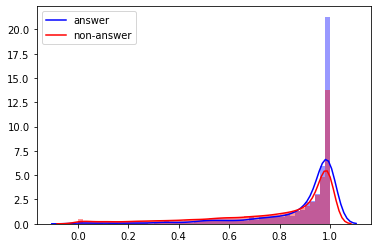

In [106]:
idx_1 = np.argwhere(y_test == 1)
idx_0 = np.argwhere(y_test == 0)
sns.distplot(np.array(y_pred_answer)[idx_1], kde_kws={'label':'answer'}, color='blue')
sns.distplot(np.array(y_pred_answer)[idx_0], kde_kws={'label':'non-answer'}, color='red')

In [112]:
y_pred_bin[0]

1

[[    0 73083]
 [    0  4951]]


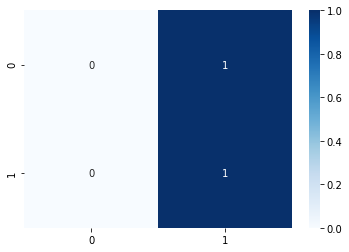

In [113]:
y_pred_bin = [ 1 if y[0] > y [1] else 1  for y in y_pred ]
y_pred_bin = np.array(y_pred_bin)

y_test = np.array(y_test).flatten()
y_pred_bin = y_pred_bin.flatten()

print(confusion_matrix(y_test, y_pred_bin))
cm = confusion_matrix(y_test, y_pred_bin)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cmap="Blues", annot=True)

In [113]:
importlib.reload(ranking)

cache = {}
bioasq_util.es = Elasticsearch(hosts=['168.176.36.10:9200'])
index_name = '2018_pubmed_baseline_title_abs_mesh'
doc_relative_url = 'http://www.ncbi.nlm.nih.gov/pubmed/'

def return_cache(q,a):
    global cache
    key = q[0:40] + a[0:40]
    if key not in cache:
        pair = { 'body':q, 'text':a, 'label':0 }
        data = transform_single_pair(pair)[0]
        cache[key] = data
    return cache[key]

def rank_text(q, a):
    try:
        #pair = qa_data.QAPair('_', q, '_', a, '_')
        pair = { 'body':q, 'text':a, 'label':0 }
        #data = return_cache(q,a)
        data = transform_single_pair(pair)[0]
        score = sim_model.predict_proba(np.expand_dims(data,axis=0))[0][0]
    except Exception as e:
        print('rank_text>>',e)
    return score

def rank_bioasq_passage(doc_id, question, passage, section):
    passage['beginSection'] = section
    passage['endSection'] = section
    passage['document'] = doc_relative_url + str(doc_id)
    passage['score'] = 0
    try:
        if (len(question)>5) & (len(passage['text'])>15):
            passage['score'] = rank_text(question, passage['text'])
    except Exception as e:
        print('rank_bioasq_passage>>',e)
        print(question)
        print(passage['text'])
        sys.exit('Error')
    return passage

def rank_document(question, doc_id, doc_title, doc_abstract):
    passages_ranked = []
    chunks_title = ranking.split_chunks(doc_title)
    title_passages_ranked = [ rank_bioasq_passage(doc_id, question, chunk, 'title') for chunk in chunks_title ]
    chunks_abstract = ranking.split_chunks(doc_abstract)
    abstract_passages_ranked = [ rank_bioasq_passage(doc_id, question, chunk, 'abstract') for chunk in chunks_abstract ]
    return title_passages_ranked + abstract_passages_ranked

def extract_rank_answer_candidates(question, docs):
    snippets = []
    w = np.linspace(0,0.0,len(docs))[::-1]
    count_pass1 = 0
    for i, doc in enumerate(docs):
        doc_id = doc.replace(doc_relative_url,'')
        doc_id, doc_title, doc_abstract = bioasq_util.get_doc(doc_id, index_name, remove_tags=True)
        #doc_id = doc[0].replace(doc_relative_url,'')
        #doc_title = doc[1]
        #doc_abstract = doc[2]
        snippets_ranked = rank_document(question, doc_id, doc_title, doc_abstract)
        count_pass1 += len(snippets_ranked)
        snippets_ranked = [ s for s in  snippets_ranked if s['score'] >= 0.6 ]
        for s in snippets_ranked:
            s['score'] = s['score'] + w[i]
        snippets.extend(snippets_ranked)
    #print('Percentage of remaining passages {}'.format(len(snippets)/count_pass1))
    return snippets

In [115]:
#evaluate over aueb documents
test_batch_docs = [ #('','8b5_ES_30_full.json')
                ('6B1_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/1-aueb-nlp-5.json'),
                ('6B2_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/2-aueb-nlp-5.json'),
                ('6B3_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/3-aueb-nlp-5.json'),
                ('6B4_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/4-aueb-nlp-5.json'),
                ('6B5_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/5-aueb-nlp-5.json')
               ]
    
df = pd.DataFrame(columns=('batch', 'Mean precision', 'Recall', 'F-Measure', 'MAP', 'GMAP'))

for i, batch_file in enumerate(test_batch_docs):
    test_batch_json = json.load(open(batch_file[1]))
    for sample in tqdm(test_batch_json['questions'], position=0):
        snippets = extract_rank_answer_candidates(sample['body'], sample['documents'])
        snippets_sorted = sorted(snippets, key = lambda i: (i['score']), reverse=True)
        sample['snippets'] = snippets_sorted[0:10]
        sample['documents'] = [ d[0] for d in sample['documents'] ][0:10]
        sample['documents'] = sample['documents'][0:10]
    submission = test_batch_json.copy()
    for q in submission['questions']:
        for s in q['snippets']:
            del s['score']
    submission_file_name =  working_folder + "/" + model_id + '_'+batch_file[1].split('/')[-1]
    json.dump(submission, open(submission_file_name, 'w'))
    docs_score, pass_score = bioasq_eval.get_scores_phaseA(batch_file[0], submission, path_home=eval_home)
    print('Document Scores',docs_score)
    print('Passage Scores',pass_score)
    df.loc[i] = [ batch_file[0].split('.')[0] + '_' + batch_file[1].split('/')[-1].split('.')[0] ] + pass_score

df.to_csv(working_folder + "/" + model_id+'.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.20142047868187313, 0.27511295809938635, 0.2029872004423393, 0.17992489965276406, 0.008677342626431389]


  0%|          | 0/100 [00:00<?, ?it/s]

Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.40612412573842244, 0.2829193579872028, 0.263402177167222, 0.3352660330422217, 0.014260726017763275]


  0%|          | 0/100 [00:00<?, ?it/s]

Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.29398680501292285, 0.3155806625975402, 0.2858036677331102, 0.2330343275723472, 0.009781087452062479]


  0%|          | 0/100 [00:00<?, ?it/s]

Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.1850105885406818, 0.24923020890773134, 0.17943505910546254, 0.15946677985694938, 0.0023439530691751506]


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.10357943113468213, 0.1361014393992736, 0.09632187464029379, 0.10066739520730479, 0.00039238302478022475]


In [ ]:
pairs_tx = p_tqdm.p_map(transform_single_pair, pairs)

for i, pair in enumerate(pairs): 
    pair['representation'] = pairs_tx[i]

In [ ]:
pairs[0]

In [ ]:
ts = transform_single_pair(pairs[0])
ts2 = transform_single_pair(pairs[1])

In [ ]:
ts3 = [ts] + [ts2]

In [ ]:
ts[0].shape

In [ ]:
w2v['test'].shape